# <font color='FFAD00'>Time Series Forecasting using XGBoost</font>

In [ ]:
import numpy as np # linear algebra
import pandas as pd
from xgboost import plot_importance, plot_tree
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10')

### <font color='FFAD00'>Mounting Google Drive</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <font color='FFAD00'>Reading the file</font>

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AI, Data Science & Analytics/raw_sales.csv')
#df = pd.read_csv('raw_sales.csv')
df.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


### <font color='FFAD00'>Data Pre-Processing</font>

In [ ]:
df['datesold'] = pd.to_datetime(df['datesold'])
df['hour'] = df['datesold'].dt.hour
df['dayofweek'] = df['datesold'].dt.dayofweek
df['quarter'] = df['datesold'].dt.quarter
df['month'] = df['datesold'].dt.month
df['year'] = df['datesold'].dt.year
df['dayofyear'] = df['datesold'].dt.dayofyear
df['sin_day'] = np.sin(df['dayofyear'])
df['cos_day'] = np.cos(df['dayofyear'])
df['dayofmonth'] = df['datesold'].dt.day
df['weekofyear'] = df['datesold'].dt.weekofyear

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


### <font color='FFAD00'>Checking the dataframe</font>

In [ ]:
df.head(5)

,datesold,postcode,price,propertyType,bedrooms,hour,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear
0,2007-02-07,2607,525000,house,4,0,2,1,2,2007,38,0.296369,0.955074,7,6
1,2007-02-27,2906,290000,house,3,0,1,1,2,2007,58,0.992873,0.119180,27,9
2,2007-03-07,2905,328000,house,3,0,2,1,3,2007,66,-0.026551,-0.999647,7,10
3,2007-03-09,2905,380000,house,4,0,4,1,3,2007,68,-0.897928,0.440143,9,10
4,2007-03-21,2906,310000,house,3,0,2,1,3,2007,80,-0.993889,-0.110387,21,12


### <font color='FFAD00'>Dropping unnecessary columns</font>

In [ ]:
df=df.drop(['datesold','postcode','propertyType','bedrooms'],axis=1)

### <font color='FFAD00'>Train-Test Split</font>

In [ ]:
df.head(5)

,price,hour,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear
0,525000,0,2,1,2,2007,38,0.296369,0.955074,7,6
1,290000,0,1,1,2,2007,58,0.992873,0.119180,27,9
2,328000,0,2,1,3,2007,66,-0.026551,-0.999647,7,10
3,380000,0,4,1,3,2007,68,-0.897928,0.440143,9,10
4,310000,0,2,1,3,2007,80,-0.993889,-0.110387,21,12


In [ ]:
len(df)

29580

In [ ]:
df_train=df[df['year']<2017]
X_train=df_train.drop(['price'],axis=1)
y_train=df_train['price']

In [ ]:
df_test=df[df['year']>=2017]
X_test=df_test.drop(['price'],axis=1)
y_test=df_test['price']

In [ ]:
df_test.head(5)

,price,hour,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear
17036,1095000,0,6,1,1,2017,1,0.841471,0.540302,1,52
17037,426000,0,1,1,1,2017,3,0.141120,-0.989992,3,1
17038,410000,0,3,1,1,2017,5,-0.958924,0.283662,5,1
17039,645000,0,3,1,1,2017,5,-0.958924,0.283662,5,1
17040,745000,0,3,1,1,2017,5,-0.958924,0.283662,5,1


In [ ]:
X_train.shape,X_test.shape

((19796, 10), (9784, 10))

### <font color='FFAD00'>Calling the XGBoost Regressor</font>

In [ ]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)


In [ ]:
yhat

array([914841.6 , 605741.75, 628168.6 , ..., 549631.75, 549631.75,
       549631.75], dtype=float32)

In [ ]:
y_test

17036    1095000
17037     426000
17038     410000
17039     645000
17040     745000
          ...   
29575     500000
29576     560000
29577     464950
29578     589000
29579     775000
Name: price, Length: 9784, dtype: int64

In [ ]:
from sklearn.metrics import mean_squared_error as MSE
rmse = np.sqrt(MSE(y_test, yhat))
print("RMSE : % f" %(rmse))

RMSE :  305639.725658


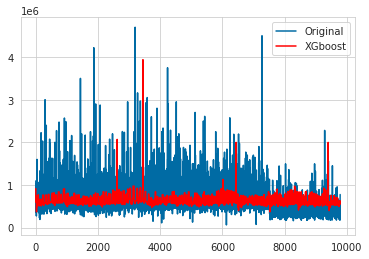

In [ ]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

### <font color='FFAD00'>Hyper Parameter Optimization</font>

In [ ]:
params = {
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}
# Initialize XGB and GridSearch
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')
grid = GridSearchCV(xgb_reg, params)
grid.fit(X_train, y_train)
gridcv_xgb = grid.best_estimator_
print(r2_score(y_test, gridcv_xgb.predict(X_test)))

0.05376697502909311


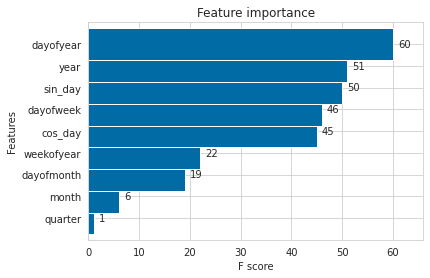

In [ ]:
_ = plot_importance(gridcv_xgb, height=1.5)

In [ ]:
gridcv_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.3,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=4, missing=None, n_estimators=100,
             n_jobs=1, nthread=-1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6, verbosity=1)

In [ ]:
yhat = grid.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error as MSE
rmse = np.sqrt(MSE(y_test, yhat))
print("RMSE : % f" %(rmse))

RMSE :  299106.485464


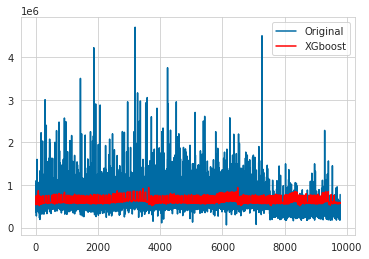

In [ ]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

### <font color='FFAD00'>Let's try fbProphet and check results</font>

In [ ]:
import pandas as pd
from fbprophet import Prophet
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AI, Data Science & Analytics/raw_sales.csv')
df['datesold'] = pd.to_datetime(df['datesold'])
df.head(5)

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07,2607,525000,house,4
1,2007-02-27,2906,290000,house,3
2,2007-03-07,2905,328000,house,3
3,2007-03-09,2905,380000,house,4
4,2007-03-21,2906,310000,house,3


In [ ]:
df_train=df[:19796]
df_test=df[19796:]

In [ ]:
df_train.shape, df_test.shape

((19796, 5), (9784, 5))

In [ ]:
df_train = df_train.rename(columns={'price': 'y', 'datesold':'ds'})
df_train['y_orig'] = df_train['y'] # to save a copy of the original data..you'll see why shortly. 
df_train['y'] = np.log(df_train['y'])


model = Prophet() #instantiate Prophet
model.add_regressor('postcode')
model.add_regressor('bedrooms')

In [ ]:
model.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
df_test = df_test.rename(columns={'price': 'y', 'datesold':'ds'})
df_test.columns

Index(['ds', 'postcode', 'y', 'propertyType', 'bedrooms'], dtype='object')

In [ ]:
future_data=df_test[['ds', 'postcode', 'bedrooms']]

In [ ]:
future_data.head(5)

,ds,postcode,bedrooms
19796,2017-10-23,2603,4
19797,2017-10-24,2615,3
19798,2017-10-24,2913,3
19799,2017-10-24,2913,3
19800,2017-10-24,2904,3


In [ ]:
forecast_data = model.predict(future_data)

forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
9774,2019-07-25,13.245976,12.911800,13.564691
9775,2019-07-26,13.055981,12.695819,13.377163
9776,2019-07-26,13.251864,12.929922,13.588527
9777,2019-07-26,13.475760,13.124710,13.799228
9778,2019-07-26,13.530228,13.187023,13.865941
9779,2019-07-26,13.477020,13.140527,13.815744
9780,2019-07-26,13.244935,12.900675,13.573858
9781,2019-07-27,13.653966,13.337215,13.984424
9782,2019-07-27,13.836621,13.488859,14.147125
9783,2019-07-27,13.887940,13.561037,14.218072


In [ ]:
from sklearn.metrics import mean_squared_error as MSE
rmse = np.sqrt(MSE((df_test['y']), np.exp(forecast_data['yhat'])))
print("RMSE : % f" %(rmse))

RMSE :  391136.679748


#### Univariate Forecasting RMSE: 341176

#### Multivariate Forecasting RMSE: 391136

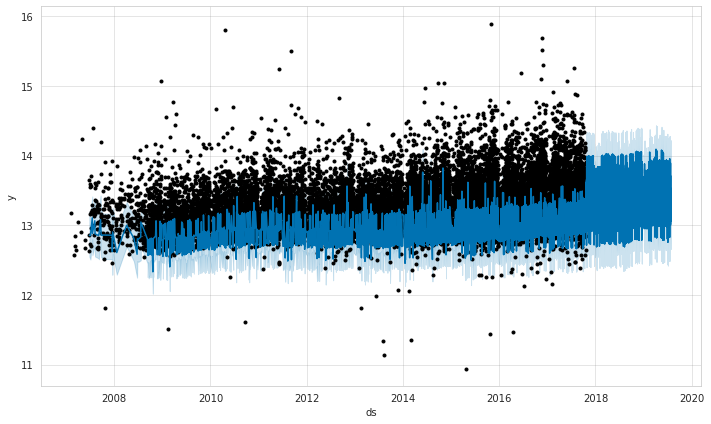

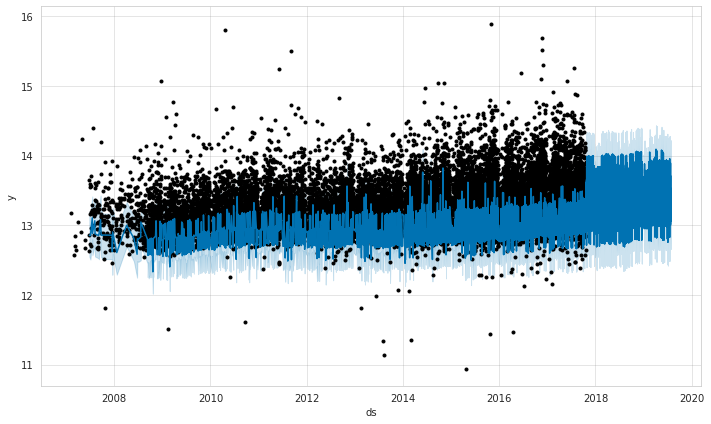

In [ ]:
model.plot(forecast_data)

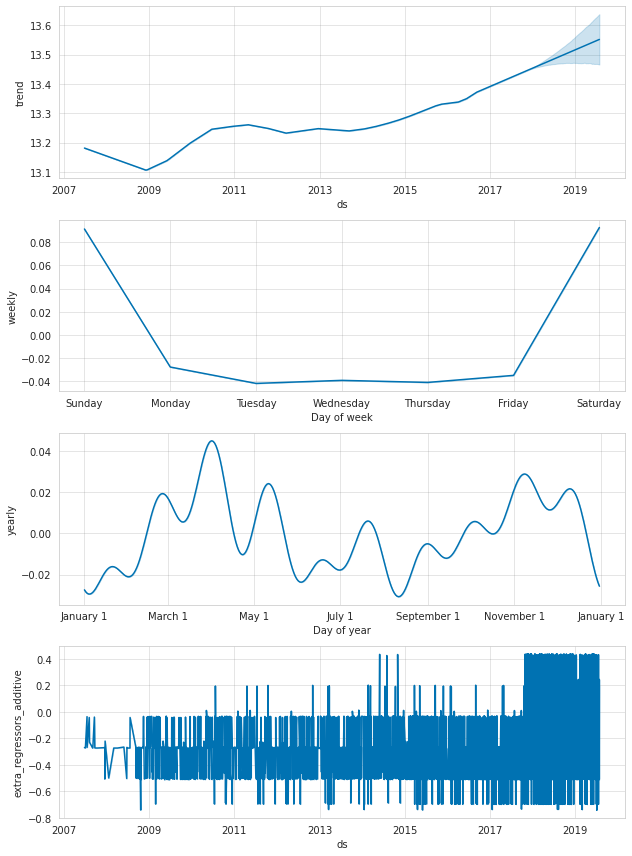

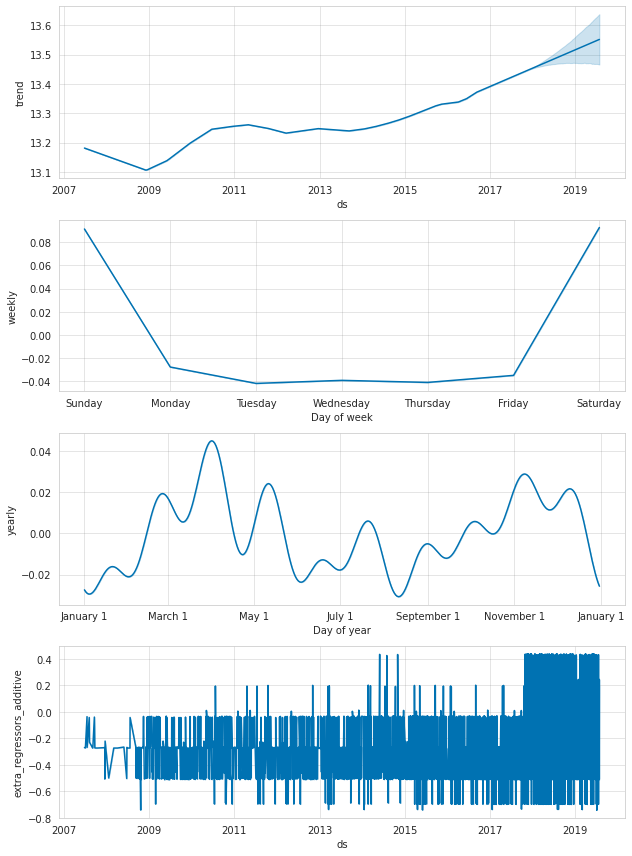

In [ ]:
model.plot_components(forecast_data)

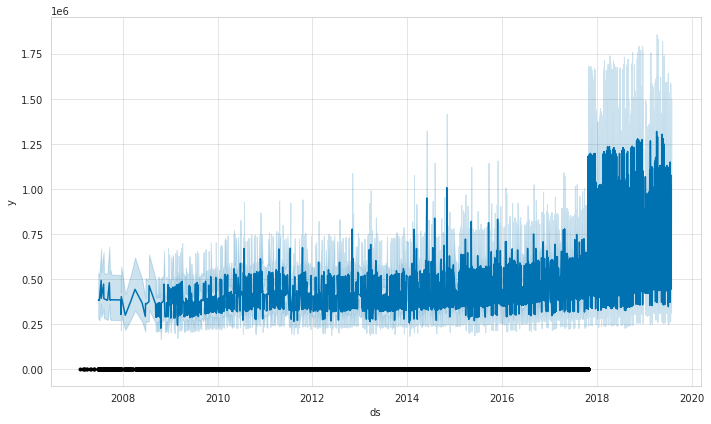

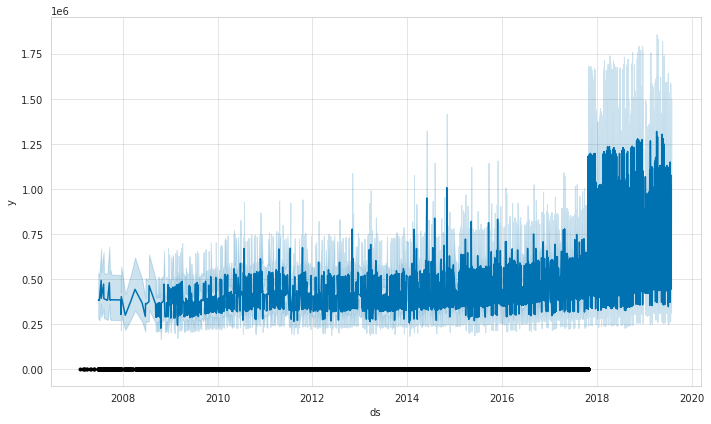

In [ ]:
forecast_data_orig = forecast_data # make sure we save the original forecast data
forecast_data_orig['yhat'] = np.exp(forecast_data_orig['yhat'])
forecast_data_orig['yhat_lower'] = np.exp(forecast_data_orig['yhat_lower'])
forecast_data_orig['yhat_upper'] = np.exp(forecast_data_orig['yhat_upper'])

model.plot(forecast_data_orig)

In [ ]:
df_test.head(5)

,ds,postcode,y,propertyType,bedrooms
19796,2017-10-23,2603,1285000,house,4
19797,2017-10-24,2615,437000,house,3
19798,2017-10-24,2913,468000,house,3
19799,2017-10-24,2913,487000,house,3
19800,2017-10-24,2904,540000,house,3


In [ ]:
final_df = pd.DataFrame(forecast_data_orig)
import plotly.graph_objs as go
import plotly.offline as py
#Plot predicted and actual line graph with X=dates, Y=Outbound
actual_chart = go.Scatter(y=df_test["y"], name= 'Actual')
predict_chart = go.Scatter(y=final_df["yhat"], name= 'Predicted')
predict_chart_upper = go.Scatter(y=final_df["yhat_upper"], name= 'Predicted Upper')
predict_chart_lower = go.Scatter(y=final_df["yhat_lower"], name= 'Predicted Lower')
py.plot([actual_chart, predict_chart, predict_chart_upper, predict_chart_lower])

'temp-plot.html'